<a href="https://colab.research.google.com/github/BurgerBecker/Earth_Engine_Colab_Guide/blob/master/EE_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!earthengine authenticate --quiet

In [2]:
!earthengine authenticate --authorization-code=""

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API


Successfully saved authorization token.


In [0]:
import numpy as np
import ee
import matplotlib.pyplot as plt
ee.Initialize()

Displays Malawi, specifically lake Chilwa. Note the wetlands and lack of outlets.

In [5]:
import folium

Peru = ee.Image("USGS/SRTMGL1_003")\
         .clip(ee.Geometry.Rectangle(-85, -20, -65,0))

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

# Use folium to visualize the imagery.
mapid = Peru.getMapId({'pallete': ['black', 'white'], 'min': 0, 'max': 3000})

map = folium.Map(location=[-15.295911875709553,35.7080608068311],zoom_start=9)
folium.TileLayer(
    tiles=EE_TILES.format(**mapid),
    attr='Google Earth Engine',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Loading Sentinel Data, we'll first look at an RGB image and then plot Band 3 (Green) vs Band 8 (NIR). After that, we can compute our data sample's Normalized Difference Water Index (NDWI).

In [0]:
def maskS2clouds(image):
  qa = image.select('QA60');

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;

  #Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0));

  return image.updateMask(mask).divide(10000);

In [0]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

In [9]:
# Get the images in the date range and remove cloud cover
Sentinel = ee.ImageCollection('COPERNICUS/S2').filterDate('2018-01-01', '2018-06-30').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).map(maskS2clouds);

# Set visualization parameters. This band combination will show RGB
rgbVis = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4_median', 'B3_median', 'B2_median'],
}

# Taking the median image value
median = Sentinel.reduce(ee.Reducer.median());

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
my_map = folium.Map(location=[-15.295911875709553,35.7080608068311], zoom_start=9)

my_map.add_ee_layer(median,rgbVis,"RGB")

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

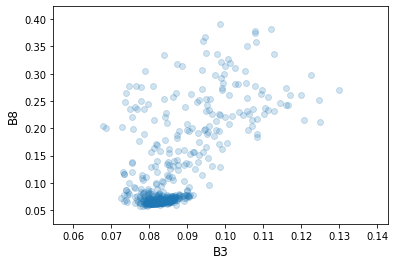

In [10]:
# I originally drew a polygon that covered the entire lake Chilwa https://en.wikipedia.org/wiki/Lake_Chilwa
# but it hit the maximum pixel limit. Look for an override on this or get it in portions.

poly = [[35.687461441596724,-15.041426642156084],
[35.61193043573735,-15.114357342226453],
[35.533652847846724,-15.343593623182487],
[35.71630055292485,-15.519656557663156]]#,
# [35.863242691596724,-15.489220276035557],
# [35.841270035346724,-15.417743582636641],
# [35.879722183784224,-15.330349783928455],
# [35.79320484979985,-15.241594444003525],
# [35.857749527534224,-15.136894492840876],
# [35.813804215034224,-15.044079105501153],
# [35.687461441596724,-15.041426642156084]]

# Define polygon

polygon = ee.Geometry.Polygon(poly)

# Point originally used

# geom = ee.Geometry.Point(35.7080608068311,-15.295911875709553);

# Select B3 and B8 bands, scale them, and sample 500 points.

samp_fc = median.select(['B3_median','B8_median']).sample(polygon,scale=30,numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3_median', 'B8_median'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('B3', fontsize=12)
plt.ylabel('B8', fontsize=12)
plt.show()

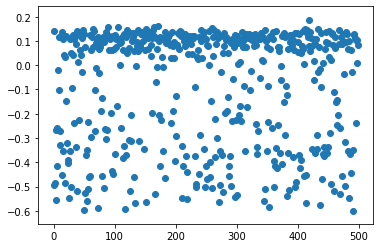

In [11]:
# https://en.wikipedia.org/wiki/Normalized_difference_water_index
# Plot sampled data's NDWI

ndwi = (np.array(samp_data[0]) - np.array(samp_data[1]))/(np.array(samp_data[0]) + np.array(samp_data[1]))
plt.scatter(range(len(ndwi)),ndwi)